In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from types import SimpleNamespace
import pytorch_lightning as pl
import os
import numpy as np
from data import EpisodicBuffer, SASRBuffer, remap_rewards
import torch
from torch.utils.data import DataLoader
from model import BCQf
import torch.nn.functional as F

In [3]:
state_dim = 64
num_actions = 25
num_subactions = 10
horizon = 20

In [4]:
pl.seed_everything(0)

Global seed set to 0


0

In [5]:
from pytorch_lightning.loggers import TestTubeLogger
logger = TestTubeLogger("logs", name="my_model")

In [6]:
import pytorch_lightning as pl
import os

In [7]:
train_buffer = SASRBuffer(state_dim, num_actions)
train_buffer.load('../data/episodes+encoded_state+knn_pibs_factored/train_data.pt')
val_episodes = EpisodicBuffer(state_dim, num_actions, horizon)
val_episodes.load('../data/episodes+encoded_state+knn_pibs_factored/val_data.pt')

Replay Buffer loaded with 165713 transitions.
Episodic Buffer loaded with 2895 episides.


In [8]:
train_buffer.action.shape, train_buffer.subaction.shape, train_buffer.subactionvec.shape

(torch.Size([165713, 1]), torch.Size([165713, 2]), torch.Size([165713, 10]))

In [9]:
train_buffer.state.shape

torch.Size([165713, 64])

In [10]:
val_episodes.state.shape, val_episodes.action.shape

(torch.Size([2895, 20, 64]), torch.Size([2895, 20, 1]))

In [11]:
train_buffer.reward = remap_rewards(train_buffer.reward, SimpleNamespace(**{'R_immed': 0.0, 'R_death': 0.0, 'R_disch': 100.0}))
val_episodes.reward = remap_rewards(val_episodes.reward, SimpleNamespace(**{'R_immed': 0.0, 'R_death': 0.0, 'R_disch': 100.0}))

In [12]:
Rmin, Rmax = float(np.min(train_buffer.reward.cpu().numpy())), float(np.max(train_buffer.reward.cpu().numpy()))

In [13]:
Rmin, Rmax

(0.0, 100.0)

In [14]:
train_buffer_loader = DataLoader(train_buffer, batch_size=100, shuffle=True)
val_episodes_loader = DataLoader(val_episodes, batch_size=len(val_episodes), shuffle=False)

In [15]:
policy = BCQf(
    state_dim=state_dim,
    num_actions=num_subactions,
    hidden_dim=256,
    lr=3e-4,
    weight_decay=1e-3,
    discount=0.99,
    eval_discount=1.0,
    threshold=0.3,
    polyak_target_update=True,
    target_update_frequency=1,
    tau=0.005,
    Rmin=Rmin,
    Rmax=Rmax,
)

In [16]:
# Check validation every N training steps
eval_frequency = 100

trainer = pl.Trainer(
    logger=logger,
    gpus=0,
    val_check_interval=eval_frequency,
    callbacks=[
        pl.callbacks.ModelCheckpoint(save_top_k=-1),
        pl.callbacks.ProgressBar(100),
    ],
)

from utils import MyTrainingEpochLoop
my_epoch_loop = MyTrainingEpochLoop(min_steps=0, max_steps=10_000)
my_epoch_loop.connect(batch_loop=trainer.fit_loop.epoch_loop.batch_loop, val_loop=trainer.fit_loop.epoch_loop.val_loop)
trainer.fit_loop.connect(epoch_loop=my_epoch_loop)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [17]:
trainer.fit(
    policy, 
    train_buffer_loader, 
    val_episodes_loader,
)

Set SLURM handle signals.

  | Name     | Type     | Params
--------------------------------------
0 | Q        | BCQf_Net | 170 K 
1 | Q_target | BCQf_Net | 170 K 
--------------------------------------
170 K     Trainable params
170 K     Non-trainable params
340 K     Total params
1.360     Total estimated model params size (MB)


Validation sanity check:   0%|          | 0/1 [00:00<?, ?it/s]

/home/tangsp/.conda/envs/py39_lightning/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/scratch/wiensj_root/wiensj1/tangsp/myRL_sepsis/a7z_BCQf/model.py:251: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  (subpibs[idx, range(lng), a_obs[:lng] % 5].cpu().numpy() * subpibs[idx, range(lng), 5+a_obs[:lng] // 5].cpu().numpy())


Global seed set to 0
/home/tangsp/.conda/envs/py39_lightning/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:   6%|▌         | 100/1674 [00:01<00:15, 98.93it/s, v_num=1]
Validating: 0it [00:00, ?it/s]
Epoch 0:  30%|██▉       | 500/1674 [00:04<00:10, 111.73it/s, v_num=1, iteration=100.0, val_qvalues=0.0405, val_wis=94.30, val_ess=137.0]
Validating: 0it [00:00, ?it/s]
Epoch 0:  42%|████▏     | 700/1674 [00:08<00:11, 87.40it/s, v_num=1, iteration=200.0, val_qvalues=0.0759, val_wis=93.10, val_ess=126.0]
Validating: 0it [00:00, ?it/s]
Epoch 0:  66%|██████▌   | 1100/1674 [00:11<00:05, 95.97it/s, v_num=1, iteration=300.0, val_qvalues=0.0789, val_wis=93.60, val_ess=133.0]
Validating: 0it [00:00, ?it/s]
Epoch 0:  78%|███████▊  | 1300/1674 [00:14<00:04, 87.38it/s, v_num=1, iteration=400.0, val_qvalues=0.147, val_wis=92.20, val_ess=151.0]
Validating: 0it [00:00, ?it/s]
Epoch 0:  96%|█████████▌| 1600/1674 [00:18<00:00, 86.84it/s, v_num=1, iteration=500.0, val_qvalues=0.271, val_wis=92.70, val_ess=165.0]
Validating: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████| 1674/1674 [00:21<00:00, 76.25it/s, v_

In [19]:
%config InlineBackend.figure_formats = ['svg']

In [20]:
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['FreeSans']

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [22]:
version_list = [1]
metas = [pd.read_csv(f'./logs/my_model/version_{ver}/meta_tags.csv').set_index('key') for ver in version_list]
tau_list = [meta.loc['threshold'][0] for meta in metas]
dfs = [pd.read_csv(f'./logs/my_model/version_{ver}/metrics.csv').iloc[:100] for ver in version_list]

In [29]:
colors = {
    '0.0': 'tab:red',
    '0.01': 'tab:orange',
    '0.05': 'tab:olive',
    '0.1': 'tab:green',
    '0.3': 'tab:cyan',
    '0.5': 'tab:blue',
    '0.7': 'tab:purple',
    '0.9999': 'tab:pink',
}

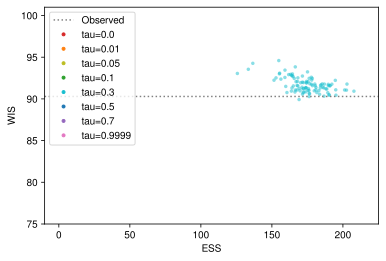

In [30]:
for tau, df in zip(tau_list, dfs):
    plt.scatter(df['val_ess'], df['val_wis'], s=50, marker='.', c=colors[tau], linewidths=0, alpha=0.5)
plt.xlabel('ESS')
plt.ylabel('WIS')
plt.xlim(-10,225)
plt.ylim(75,101)
plt.axhline(90.2936, ls=':', c='grey', label='Observed')
for tau, c in colors.items():
    plt.plot(0, 0, '.', c=colors[tau], label=f'tau={tau}')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['FreeSans']
from utils import ewma_vectorized

In [ ]:
alpha_param = 0.10

tau_list = [0.3]
version_list = [1]

dfs = [pd.read_csv(f'./logs/my_model/version_{ver}/metrics.csv').iloc[1:] for (tau, ver) in zip(tau_list, version_list)]

for tau, df in zip(tau_list, dfs):
    plt.plot(df['iteration'], ewma_vectorized(df['val_qvalues'], alpha_param), label=f'tau={tau}')
    plt.plot(df['iteration'], df['val_qvalues'], alpha=0.1, c=plt.gca().lines[-1].get_color())

# plt.axhline(100, ls=':', c='grey')
plt.xlabel('Training Iterations')
plt.ylabel('Predicted Q-values')
plt.legend()
plt.show()

for tau, df in zip(tau_list, dfs):
    plt.plot(df['iteration'], ewma_vectorized(df['val_wis'], alpha_param)*50+50, label=f'tau={tau}')
    plt.plot(df['iteration'], df['val_wis']*50+50, alpha=0.1, c=plt.gca().lines[-1].get_color())
    plt.gca().annotate(f"{df['val_wis'].max()*50+50:.2f}", (df.loc[df['val_wis'].idxmax()]['iteration'], df['val_wis'].max()*50+50))
    plt.plot(df.loc[df['val_wis'].idxmax()]['iteration'], df['val_wis'].max()*50+50, 'o', c=plt.gca().lines[-1].get_color())

plt.axhline(72.3632/2+50, ls=':', c='grey', label='Observed')
plt.xlabel('Training Iterations')
plt.ylabel('Validation WIS')
plt.legend()
plt.show()

for tau, df in zip(tau_list, dfs):
    plt.plot(df['iteration'], ewma_vectorized(df['val_ess'], alpha_param), label=f'tau={tau}')
    plt.plot(df['iteration'], df['val_ess'], alpha=0.1, c=plt.gca().lines[-1].get_color())
    plt.gca().annotate(f"{df['val_ess'].max():.2f}", (df.loc[df['val_ess'].idxmax()]['iteration'], df['val_ess'].max()))
    plt.plot(df.loc[df['val_ess'].idxmax()]['iteration'], df['val_ess'].max(), 'o', c=plt.gca().lines[-1].get_color())

plt.axhline(200, ls='--', c='grey', label='ESS cutoff')
plt.xlabel('Training Iterations')
plt.ylabel('Validation ESS')
plt.legend()
plt.show()